<a href="https://colab.research.google.com/github/kindertjd/FineTuneLLM/blob/main/module-4/research-assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation.

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows.

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection`
* Users can choose any set of input sources for their research.
  
`Planning`
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state.
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format`
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format.

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## Setup

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")


In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [6]:

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-DEMO"

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [7]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

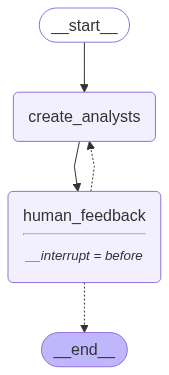

In [16]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:

{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):

    """ Create analysts """

    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback,
                                                            max_analysts=max_analysts)

    # Generate question
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])

    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"

    # Otherwise end
    return END

# Add nodes and edges
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts",END])


# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [40]:
# Input
max_analysts = 1
topic = "What to do now as parent to make a 5 years old a future tennis star"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: International Tennis Federation
Role: Child Development Specialist
Description: Dr. Emily Carter focuses on the developmental stages of children and how early exposure to sports can influence their future potential. Her primary concern is ensuring that the child’s physical and mental development is balanced and that the pressure to excel does not hinder their natural growth. She advocates for a supportive environment that encourages a love for the sport rather than a focus solely on competitive success.
--------------------------------------------------
Name: Dr. Emily Carter
Affiliation: International Tennis Federation
Role: Child Development Specialist
Description: Dr. Emily Carter focuses on the developmental stages of children and how early exposure to sports can influence their future potential. She is particularly interested in how parents can nurture a child's interest and skills in tennis from a young age, ensuring a balance between physical 

In [20]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [21]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback":
                            "Add in someone from a professional tennis to add an sport athlete perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f036458-d257-6e5b-8002-21e2d4a7a581'}}

In [22]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: International Tennis Federation
Role: Child Development Specialist
Description: Dr. Carter focuses on the psychological and emotional development of young athletes. She is concerned with ensuring that the child enjoys the sport and develops a healthy relationship with competition. Her motive is to promote a balanced approach to training that supports mental well-being and long-term passion for tennis.
--------------------------------------------------
Name: Coach Mark Thompson
Affiliation: USTA Player Development
Role: Youth Tennis Coach
Description: Coach Thompson is dedicated to the technical and tactical development of young tennis players. He emphasizes the importance of foundational skills and early exposure to the sport. His concern is to create a structured yet fun training environment that fosters skill acquisition and a love for the game.
--------------------------------------------------
Name: Dr. Sarah Lin
Affiliation: Sports Nutrition Ass

In [27]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback":
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f036467-16a7-6b5e-8005-cce0c91653d6'}}

In [43]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [36]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [44]:
final_state.next

()

In [45]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Name: Dr. Emily Carter
Affiliation: International Tennis Federation
Role: Child Development Specialist
Description: Dr. Emily Carter focuses on the developmental stages of children and how early exposure to sports can influence their future potential. She is particularly interested in how parents can nurture a child's interest and skills in tennis from a young age, ensuring a balance between physical training and mental well-being.
--------------------------------------------------


## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [86]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [87]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [88]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [89]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [90]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

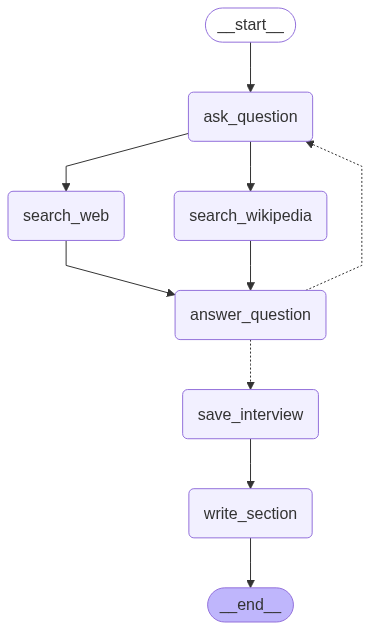

In [91]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert.

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):

    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state: InterviewState):

    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}.

You goal is to answer a question posed by the interviewer.

To answer question, use this context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:

[1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):

    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from the expert
    answer.name = "expert"

    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):

    """ Save interviews """

    # Get messages
    messages = state["messages"]

    # Convert interview to a string
    interview = get_buffer_string(messages)

    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState,
                   name: str = "expert"):

    """ Route between question and answer """

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer.

Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst:
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")])

    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [92]:
# Pick one analyst
analysts[0]

Analyst(affiliation='International Tennis Federation', name='Dr. Emily Carter', role='Child Development Specialist', description="Dr. Emily Carter focuses on the developmental stages of children and how early exposure to sports can influence their future potential. She is particularly interested in how parents can nurture a child's interest and skills in tennis from a young age, ensuring a balance between physical training and mental well-being.")

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [93]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Nurturing Young Tennis Enthusiasts: A Balanced Approach to Development

### Summary

The developmental stages of children are crucial in shaping their future potential, particularly in sports like tennis. Early exposure to sports can significantly influence a child's interest and skills, and parents play a pivotal role in nurturing this potential. Dr. Emily Carter's focus on the balance between physical training and mental well-being in young tennis players highlights the importance of a holistic approach to development.

One of the key insights from the sources is the emphasis on developing an empathetic and knowledgeable parenting mindset. Parents are encouraged to understand the psychological demands of tennis and to adopt a values-based approach in nurturing their child's mental and emotional skills [1]. This involves working collaboratively with coaches to develop specific characteristics and skills in their children, ensuring that the focus is not solely on winning but on personal growth and self-challenge.

Another interesting aspect is the recommendation to teach young children to love tennis by focusing on coordination and motor skills rather than racquet skills initially [2]. This approach helps in building a strong foundation for future skill development while keeping the learning process enjoyable and engaging for the child.

Furthermore, the role of play in child development is highlighted as a crucial element. Play is not just a pastime but a tool that aids in physical, cognitive, and social development [3]. Structured and unstructured play, including tennis games, can enhance skills such as balance, coordination, agility, and speed, which are essential for tennis [4]. These activities also foster resilience and confidence, empowering children to reach their full potential in the sport [5].

In summary, nurturing a child's interest and skills in tennis requires a balanced approach that combines physical training with mental and emotional development. Parents should focus on creating a supportive environment that encourages personal growth, resilience, and a love for the game. By doing so, they can help their children develop the skills and mindset needed to succeed in tennis and beyond.

### Sources
[1] https://www.lta.org.uk/48f191/globalassets/mental-emotional-skills-guide-a5.pdf  
[2] https://www.reddit.com/r/10s/comments/1h6uzht/what_to_teach_fiveyearolds_about_tennis/  
[3] https://en.wikipedia.org/wiki/Play_(activity)  
[4] https://www.i9sports.com/blog/7-tennis-games-for-kids  
[5] https://siliconvalleytennis.com/how-parents-can-support-their-kids-to-reach-their-full-potential-in-tennis-2/  

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [95]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

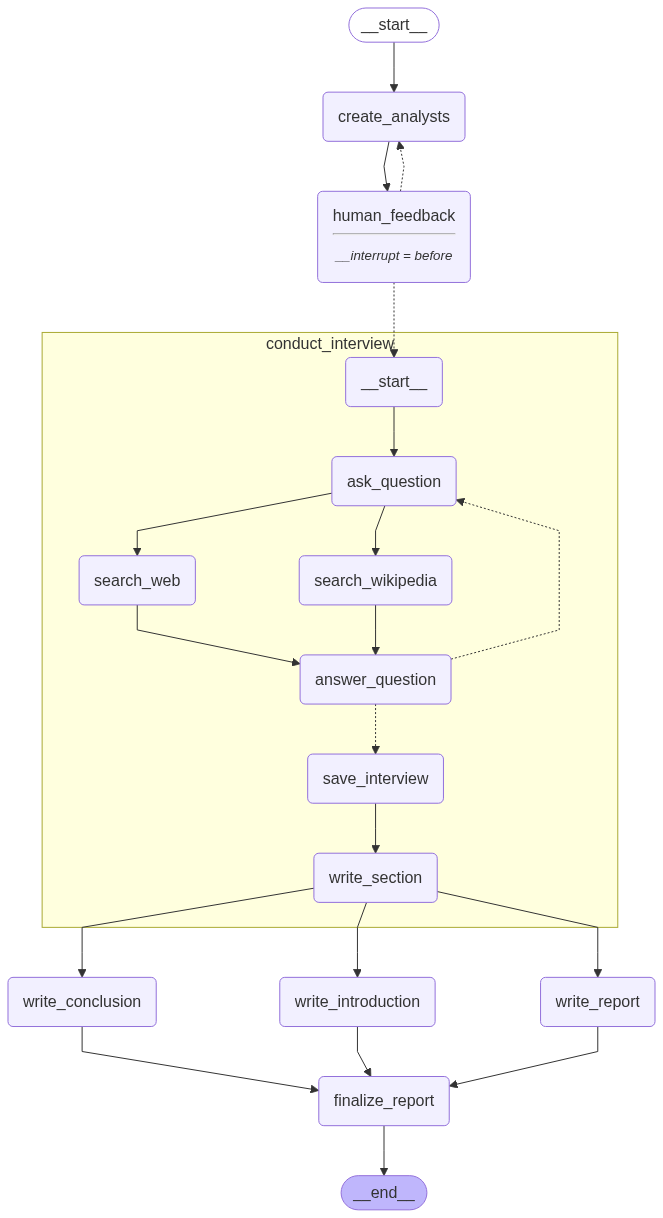

In [100]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos.
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")])
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")])
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")])
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [101]:
# Inputs
max_analysts = 3
topic = "How to educate a 5 years old to be a top tennis athelete like Sinner or Alcaraz"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts},
                          thread,
                          stream_mode="values"):

    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Youth Sports Development Institute
Role: Child Development Specialist
Description: Dr. Carter focuses on the cognitive and emotional development of young children in sports. She is particularly interested in how early exposure to structured sports training can influence a child's long-term athletic potential and psychological well-being. Her work emphasizes the importance of balancing skill development with play and creativity to foster a lifelong love for the sport.
--------------------------------------------------
Name: Coach Rafael Martinez
Affiliation: Elite Tennis Coaching Academy
Role: Tennis Coaching Expert
Description: Coach Martinez specializes in developing young tennis talent through innovative training techniques. He is dedicated to identifying and nurturing the physical and technical skills necessary for young athletes to excel in tennis. His approach includes personalized training regimens that adapt to the unique abilities and growth 

In [106]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback":
                                "Add in pro tennis athelete like Roger Federer as analysts. Roger was the world number one in ATP tour"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f036548-d24d-64c8-8006-7fb750ab2de4'}}

In [107]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Roger Federer
Affiliation: Tennis Academy
Role: Pro Tennis Athlete
Description: Roger Federer focuses on the importance of developing a strong foundational skill set in young athletes. He emphasizes the need for a balance between technical training and fostering a love for the game. His approach is to ensure that young players enjoy the sport while gradually building their skills.
--------------------------------------------------
Name: Dr. Emily Carter
Affiliation: Child Development Research Institute
Role: Child Psychologist
Description: Dr. Emily Carter is concerned with the psychological and emotional development of young athletes. She highlights the importance of creating a supportive environment that encourages resilience and a growth mindset. Her focus is on ensuring that the child’s mental well-being is prioritized alongside their athletic development.
--------------------------------------------------
Name: Professor John Smith
Affiliation: Sports Science University
Role

In [108]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback":
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03654a-297a-695f-8008-4809d644f429'}}

In [109]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [110]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# How to Educate a 5-Year-Old to Be a Top Tennis Athlete Like Sinner or Alcaraz

## Introduction

In the quest to nurture the next generation of tennis champions, understanding the unique needs of young athletes is paramount. This report delves into the multifaceted approach required to educate a five-year-old to excel in tennis, drawing inspiration from stars like Jannik Sinner and Carlos Alcaraz. We explore the importance of a balanced approach to early sports education, emphasizing cognitive and emotional development alongside physical training. Insights from Roger Federer highlight foundational skills and mental toughness, while Dr. Michael Thompson's expertise in biomechanics and injury prevention offers strategies to optimize training. Together, these elements form a comprehensive guide to fostering both athletic prowess and personal growth in young tennis players.

---



Educating a five-year-old to become a top tennis athlete like Sinner or Alcaraz requires a multifaceted approach that balances physical, cognitive, and emotional development. The insights from experts highlight the importance of age-appropriate training methods, foundational skills, mental toughness, and injury prevention strategies.

At the core of early sports education is the need to foster a love for tennis while preventing burnout. This involves engaging children in activities that enhance their physical health, such as improving hand-eye coordination, agility, and balance [2]. Sports participation also plays a crucial role in social and emotional development, teaching teamwork, sportsmanship, and communication [2]. Parents and coaches are pivotal in nurturing a child's mental and emotional skills by adopting a values-based approach that emphasizes empathy and understanding of the psychological demands of sports [3]. Providing young athletes with choices in their training can empower them and prevent burnout [4].

Roger Federer emphasizes the importance of developing foundational skills and mental toughness. Physical conditioning, including core strength exercises, speed drills, and flexibility training, is essential for young athletes [1]. These exercises educate young players on good functional biomechanics, crucial for injury prevention. Footwork drills, such as suicides and jumping rope, improve agility and coordination, laying the groundwork for advanced techniques [3]. Mental toughness is equally important, with young players learning to cope with competition pressures and developing resilience through mindfulness techniques and constructive feedback [4][5].

Optimizing training for young tennis players involves a comprehensive approach that integrates biomechanics and kinesiology principles. Proper biomechanical assessments can prevent injuries and optimize performance by ensuring efficient body function [1]. Despite the importance of biomechanics, there is a lack of interventional studies on junior elite players, highlighting the need for evidence-based training programs [2]. Specific biomechanical evaluations, such as the Serve Efficiency Rating (SER) and Injury Risk Assessment (IRA), provide valuable metrics for improving performance and reducing injury risks [2]. Strength and conditioning programs targeting muscular imbalances, along with plyometric exercises and agility drills, are crucial for developing explosive power and coordination [3][4]. Kinesiology principles, such as adaptation through exercise, enhance fitness and neuromotor control, reducing injury risks and improving performance [5].

In conclusion, educating a young child to become a top tennis athlete involves a balanced approach that combines age-appropriate training, parental involvement, foundational skills development, mental resilience, and injury prevention strategies. By focusing on both athletic and personal growth, young athletes can develop a lifelong love for tennis and achieve success in the competitive world of sports.


---

## Conclusion

In nurturing a five-year-old to become a top tennis athlete like Sinner or Alcaraz, a balanced approach to early sports education is essential. This report highlights the importance of age-appropriate training that supports both athletic and personal growth, emphasizing the role of parents and coaches in fostering a positive sports environment. Roger Federer's insights underscore the need for foundational skills and mental toughness, while Dr. Michael Thompson's focus on biomechanics and injury prevention offers a scientific basis for optimizing training. By integrating these elements, young athletes can develop a lifelong love for tennis, achieve peak performance, and minimize injury risks.

## Sources
[1] https://itfcoachingreview.com/index.php/journal/article/view/310/885  
[2] https://rtninsurance.com/blog/tennis-basics/tennis-drills-for-5-year-olds  
[3] https://www.lta.org.uk/48f191/globalassets/mental-emotional-skills-guide-a5.pdf  
[4] https://idahoyouthsports.com/burnout-prevention-strategies-for-coaches-parents-and-athletes  
[5] https://siliconvalleytennis.com/essential-training-for-young-tennis-players/  
[6] https://en.wikipedia.org/wiki/Kinesiology  
[7] https://www.quora.com/Tennis-how-to-teach-footwork-to-5-7-year-olds  
[8] https://www.usta.com/en/home/stay-current/eastern/how-junior-tennis-players-can-improve-their-mental-strength.html  
[9] https://siliconvalleytennis.com/helping-young-players-improve-their-mental-game-in-tennis/  
[10] https://www.honsbergerphysio.com/blog/Tennis-Biomechanics~18967.html  
[11] https://med.emory.edu/departments/orthopaedics/_documents/tennis-player-comprehensive-care-emory-2020_compressed.pdf  
[12] https://www.researchgate.net/publication/232195360_Common_Injuries_in_Tennis_Players_Exercises_to_Address_Muscular_Imbalances_and_Reduce_Injury_Risk

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r